# Step 2 - CRSS Comprehensive Fatality Analysis with Survey Weights
## Identifying Key Factors in Fatal Crash Outcomes

### Summary
This analysis uses the Crash Report Sampling System (CRSS) 2023 dataset to identify which factors most strongly influence whether a crash results in a fatality. The CRSS uses complex survey sampling, so proper weighting is essential for accurate national estimates.

### Analysis Goals:
- Identify individual features most predictive of fatalities
- Group related features into categories and assess their collective impact
- Compare weighted vs unweighted results to demonstrate importance of proper sampling methods
- Provide actionable insights for crash prevention strategies


## This notebook contains



In [1]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.inspection import permutation_importance

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("All packages imported successfully")

All packages imported successfully


## 1. Define Mixed Numeric/Categorical Variable Rules

Variables Corrected:
- ALC_RES (Blood Alcohol Content): 0-939 -> divide by 100 to get actual BAC
- AGE: 0-120 years (998-999 = unknown)
- VSPD_LIM (Speed Limit): 0-90 mph (98-99 = unknown)
- MOD_YEAR (Vehicle Year): 1900-2100 (9999 = unknown)


In [2]:
# Define mixed numeric/categorical variables and their thresholds
MIXED_VARIABLES = {
    'ALC_RES': {
        'numeric_range': (0, 939),
        'categorical_codes': {940: 'BAC >= 0.94', 995: 'Not Reported', 996: 'Test Not Given',
                             997: 'Test Performed, Results Unknown', 998: 'Positive Reading',
                             999: 'Unknown if Tested', -999: 'Unknown if Tested'},
        'transform': 'divide_100',
        'create_binary': None
    },
    'DRINKING': {
        'numeric_range': (0, 1),
        'categorical_codes': {9: 'Unknown', 8: 'Not Reported'},
        'transform': 'divide_100',
        'create_binary': None
    },
    'EJECTED': {
        'numeric_range': (0, 3),
        'categorical_codes': {9: 'Unknown', 8: 'Not applicable', 7: 'Not Reported'},
        'transform': None,
        'create_binary': None
    },
    'RELJCT': {
        'numeric_range': (0, 1),
        'categorical_codes': {9: 'Unknown', 8: 'Not Reported'},
        'transform': None,
        'create_binary': None
    },
    'SEX': {
        'numeric_range': (0,0),
        'categorical_codes': {1: 'Male', 2: 'Female',9: 'Unknown',8: 'Not Reported'},
        'transform': None,
        'create_binary': None
    },
    'AGE': {
        'numeric_range': (0, 120),
        'categorical_codes': {998: 'Not Reported', 999: 'Unknown'},
        'transform': None,
        'create_binary': None
    },
    'VSPD_LIM': {
        'numeric_range': (0, 90),
        'categorical_codes': {98: 'Not Reported', 99: 'Unknown'},
        'transform': None,
        'create_binary': None
    },
    'MOD_YEAR': {
        'numeric_range': (1900, 2100),
        'categorical_codes': {9999: 'Unknown'},
        'transform': None,
        'create_binary': None
    }
}

print("Mixed variable rules defined for", len(MIXED_VARIABLES), "variables")

Mixed variable rules defined for 8 variables


## 2. Load Data and Extract Weights

Load the preprocessed CRSS person-level dataset -> Locate and validate the WEIGHT variable -> Compare weighted vs unweighted fatality rates -> Visualize weight distributions


With consideration of weights:
- Results will represent national estimates of crash patterns
- Each observation is weighted by its inverse selection probability
- Produces unbiased estimates more suitable for policy recommendations for example

The CRSS manual explicitly warns: *"Treating the CRSS sample as a simple random sample in estimation may cause severe bias to both point estimates and standard error estimates."*


In [ ]:
# Configuration
DATA_PATH = Path("Dataset/Regression/person_level_integrated_CRSS.parquet")
TARGET_COL = 'FATALITY'
WEIGHT_COL = 'WEIGHT'
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Load data
print("Loading CRSS data...")
df = pd.read_parquet(DATA_PATH)
print(f"Dataset shape: {df.shape}")

# Check for weight column
if WEIGHT_COL not in df.columns:
    print(f"\nWARNING: '{WEIGHT_COL}' column not found!")
    print(f"Available columns containing 'weight': {[c for c in df.columns if 'weight' in c.lower()]}")
    # Try to find weight column with different name
    weight_cols = [c for c in df.columns if 'weight' in c.lower() and 'ratwgt' not in c.lower()]
    if weight_cols:
        WEIGHT_COL = weight_cols[0]
        print(f"Using '{WEIGHT_COL}' instead")
    else:
        print("\nCRITICAL: No weight column found. Analysis will proceed unweighted.")
        print("This may produce biased estimates!")
        df[WEIGHT_COL] = 1.0  # Uniform weights (unweighted)
else:
    print(f"\n✓ Weight column '{WEIGHT_COL}' found")

# print(f"WEIGHT sample:\n{df[WEIGHT_COL].head()}")
df[WEIGHT_COL] = (pd.to_numeric(df[WEIGHT_COL], errors="coerce")).astype(float)
# print(f"WEIGHT sample:\n{df[WEIGHT_COL].head()}")

# Ensure target variable exists
print("\nChecking FATALITY target variable...")

# Check if MAX_SEV exists
if "MAX_SEV" not in df.columns:
    raise ValueError("MAX_SEV column not found in dataset! Cannot create FATALITY target.")

# ALWAYS create/recreate FATALITY from MAX_SEV (don't trust existing column)
print("Creating FATALITY variable from MAX_SEV...")
print(f"  MAX_SEV unique values: {sorted(df['MAX_SEV'].dropna().unique())}")

# Convert MAX_SEV to numeric
df['MAX_SEV'] = pd.to_numeric(df['MAX_SEV'], errors='coerce')

# Create FATALITY: 1 if MAX_SEV == 4 (fatal injury), 0 otherwise
df[TARGET_COL] = (df['MAX_SEV'] == 4).astype(int)

# Verification
print(f"  FATALITY created:")
print(f"    Value counts: {df[TARGET_COL].value_counts().to_dict()}")
print(f"    Data type: {df[TARGET_COL].dtype}")

# Safety check - ensure we actually have some fatalities
if df[TARGET_COL].sum() == 0:
    print("\nERROR: No fatalities found in dataset!")
    print("   This suggests a problem with MAX_SEV or data extraction.")
    print("   Checking MAX_SEV distribution:")
    print(df['MAX_SEV'].value_counts().sort_index())
    raise ValueError("No fatalities in dataset - check MAX_SEV encoding")

print("Checking person type values (verifying only vehicle occupants present...)")
print(f"  per_typ unique values: {sorted(df['PER_TYP'].unique())}")
# Calculate weighted and unweighted fatality rates
unweighted_rate = df[TARGET_COL].mean()
weighted_rate = np.average(df[TARGET_COL], weights=df[WEIGHT_COL])


print("FATALITY RATES")

print(f"Unweighted: {unweighted_rate:.4%} ({df[TARGET_COL].sum():,} / {len(df):,})")
print(f"Weighted:   {weighted_rate:.4%} (national estimate)")
print(f"Difference: {abs(weighted_rate - unweighted_rate):.4%}")

Loading CRSS data...
Dataset shape: (117033, 359)

✓ Weight column 'WEIGHT' found

Checking FATALITY target variable...
Creating FATALITY variable from MAX_SEV...
  MAX_SEV unique values: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
  FATALITY created:
    Value counts: {0: 114520, 1: 2513}
    Data type: int64
Checking person type values (verifying only vehicle occupants present...)
  per_typ unique values: [1, 2, 3, 4, 9]
FATALITY RATES
Unweighted: 2.1473% (2,513 / 117,033)
Weighted:   0.5630% (national estimate)
Difference: 1.5842%


## 3. Process Mixed Numeric/Categorical Variables

Some variables are mixed categorical and numerical values (ie; For ALC_RES, 0-939 are actual numerical measurements, but anything above is categorized depending on the value such as 995="Not Reported") so I am correcting each of these by:

1. Converting to Numeric values
2. Identifying Categorical Codes: Finding values outside valid range
3. Creating Binary Indicators: Flagging valid measurements (e.g., ALC_TEST_GIVEN)
4. Replacing Codes with NaN: Converting categorical codes to missing values
5. Applying Transformations: E.g., divide ALC_RES by 100

In [4]:
def process_mixed_variable(df, var_name, rules):
    """Process mixed numeric/categorical variables"""
    if var_name not in df.columns:
        return df
    
    print(f"\nProcessing {var_name}...")
    df[var_name] = pd.to_numeric(df[var_name], errors='coerce')
    
    # Identify categorical codes
    categorical_mask = pd.Series(False, index=df.index)
    for code in rules['categorical_codes'].keys():
        categorical_mask |= (df[var_name] == code)
    
    # Check range
    min_val, max_val = rules['numeric_range']
    outside_range = (df[var_name].notna() & 
                    ((df[var_name] < min_val) | (df[var_name] > max_val)) &
                    ~categorical_mask)
    
    # Create binary if requested
    if rules['create_binary']:
        binary_name = rules['create_binary']
        df[binary_name] = ((df[var_name] >= min_val) & 
                          (df[var_name] <= max_val) & 
                          df[var_name].notna()).astype(int)
        print(f"  Created binary: {binary_name}")
    
    # Convert categorical to NaN
    df.loc[categorical_mask | outside_range, var_name] = np.nan
    
    # Transform
    if rules['transform'] == 'divide_100':
        df[var_name] = df[var_name] / 100.0
    
    n_valid = df[var_name].notna().sum()
    print(f"  Valid: {n_valid:,} ({n_valid/len(df)*100:.1f}%)")
    if n_valid > 0:
        print(f"  Range: [{df[var_name].min():.2f}, {df[var_name].max():.2f}]")
    
    return df


In [5]:
for var_name, rules in MIXED_VARIABLES.items():
    df = process_mixed_variable(df, var_name, rules)


Processing ALC_RES...
  Valid: 1,235 (1.1%)
  Range: [0.00, 6.50]

Processing DRINKING...
  Valid: 60,677 (51.8%)
  Range: [0.00, 0.01]

Processing SEX...
  Valid: 0 (0.0%)

Processing AGE...
  Valid: 109,534 (93.6%)
  Range: [0.00, 115.00]

Processing VSPD_LIM...
  Valid: 98,963 (84.6%)
  Range: [0.00, 80.00]

Processing MOD_YEAR...
  Valid: 112,668 (96.3%)
  Range: [1923.00, 2024.00]


## 4. Feature Selection and Preprocessing

Many of the variables cover features belonging to similar categories. It's valuable to see how each of these individual categories influences fatalities, but I also want to see how the grouped categories might nfluence the outcome (for example, instead of seeing seatbelts, airbags, alcohol, drugs, in a list, I could see safety equipment vs substance use and compare how those impact the outcome)

Excluding any variables not relevant to this analysis:
- **Identifiers**: CASENUM, VEH_NO, PER_NO,STRATUM 
- **Outcomes**: INJ_SEV, MAX_SEV (consequences, not causes)
- **Post-Crash**: Hospital arrival times (occur after outcome)
- **Geographic IDs**: Specific lat/long, county codes
- **Weights**: WEIGHT, RATWGT (analysis tools, not features)


In [6]:
# Define feature categories
FEATURE_CATEGORIES = {
    'demographics': {
        'columns': ['AGE', 'SEX', 'RACE', 'HISPANIC'],
        'description': 'Person demographics'
    },
    'safety_equipment': {
        'columns': ['REST_USE', 'REST_MIS', 'AIR_BAG', 'HELM_USE', 'HELM_MIS'],
        'description': 'Seatbelt, airbag, helmet usage'
    },
    'person_position': {
        'columns': ['SEAT_POS', 'PER_TYP', 'EJECTION', 'EJ_PATH', 'EXTRICAT'],
        'description': 'Seating position and ejection status'
    },
    'substance_use': {
        'columns': ['DRINKING', 'DR_DRINK', 'ALC_RES', 'ALC_TEST_GIVEN',
                   'DRUGS', 'DRUG_DET', 'DRUGRES1', 'DRUGRES2', 'DRUGRES3'],
        'description': 'Alcohol and drug involvement'
    },
    'vehicle_type': {
        'columns': ['BODY_TYP', 'MOD_YEAR', 'VEH_CF1', 'VEH_CF2', 'GVWR', 'V_CONFIG'],
        'description': 'Vehicle characteristics'
    },
    'crash_dynamics': {
        'columns': ['IMPACT1', 'DEFORMED', 'FIRE_EXP', 'ROLLOVER', 'ROLINLOC',
                   'HARM_EV', 'MAN_COLL', 'NUMOCCS'],
        'description': 'Impact, fire, rollover'
    },
    'speed_behavior': {
        'columns': ['SPEEDREL', 'VSPD_LIM', 'VALIGN', 'VPROFILE'],
        'description': 'Speed-related factors'
    },
    'environmental': {
        'columns': ['WEATHER', 'WEATHER1', 'WEATHER2', 'LGT_COND', 'VPAVETYP', 'VSURCOND'],
        'description': 'Weather, lighting, surface'
    },
    'temporal': {
        'columns': ['HOUR', 'MINUTE', 'DAY_WEEK', 'MONTH'],
        'description': 'Time-related factors'
    },
    'roadway': {
        'columns': ['RELJCT1', 'RELJCT2', 'TYP_INT', 'REL_ROAD', 'VTRAFWAY',
                   'VNUM_LAN', 'WRK_ZONE', 'VTRAFCON', 'FUNC_SYS', 'RUR_URB'],
        'description': 'Road type, junction, traffic control'
    },
    'commercial': {
        'columns': ['BUS_USE', 'SPEC_USE', 'EMER_USE', 'CARGO_BT', 'HAZ_INV'],
        'description': 'Commercial vehicle use'
    }
}

# Columns to exclude
EXCLUDE_COLS = [
    TARGET_COL, WEIGHT_COL,  # Target and weight
    "CASENUM", "VEH_NO", "PER_NO", "ST_CASE",  # IDs
    "PSU", "PSU_VAR", "PSUSTRAT", "REGION", "PJ", "STATE", "COUNTY",  # Sampling
    "STRATUM",  # Circular with fatality
    "INJ_SEV", "MAX_SEV", "DEATH_HR", "DEATH_MN",  # Outcomes
    "LATITUDE", "LONGITUD",  # Geographic
    "NOT_HOUR", "NOT_MIN", "ARR_HOUR", "ARR_MIN", "HOSP_HR", "HOSP_MN",  # Post-crash
    "RATWGT"  # Alternative weight
]

print(f"Feature categories defined: {len(FEATURE_CATEGORIES)}")

Feature categories defined: 11


In [7]:
# Collect features
all_feature_cols = []
for cat_info in FEATURE_CATEGORIES.values():
    all_feature_cols.extend(cat_info['columns'])

available_features = [col for col in all_feature_cols if col in df.columns]
print(f"Available features: {len(available_features)} / {len(all_feature_cols)}")

# Extract target, weights, and features
y = df[TARGET_COL].copy()
weights = df[WEIGHT_COL].copy()
X = df[available_features].copy()

print(f"\nInitial shapes:")
print(f"  Features: {X.shape}")
print(f"  Target: {y.shape}")
print(f"  Weights: {weights.shape}")

Available features: 47 / 66

Initial shapes:
  Features: (117033, 47)
  Target: (117033,)
  Weights: (117033,)


In [8]:
# Preprocessing
print("Converting to numeric...")
X_numeric = X.apply(pd.to_numeric, errors='coerce')

# Drop non-numeric
non_numeric_cols = X_numeric.columns[X_numeric.isna().all()].tolist()
if non_numeric_cols:
    print(f"Dropping {len(non_numeric_cols)} non-numeric columns")
    X_numeric = X_numeric.drop(columns=non_numeric_cols)

# Remove infinite values
X_numeric = X_numeric.replace([np.inf, -np.inf], np.nan)

# Align with valid targets and weights
valid_idx = y.notna() & weights.notna() & (weights > 0)
y_clean = y[valid_idx]
weights_clean = weights[valid_idx]
X_clean = X_numeric[valid_idx]

print(f"Removed {(~valid_idx).sum()} rows with missing target/weights")

# Drop high-missing features
missing_pct = (X_clean.isna().sum() / len(X_clean) * 100)
high_missing = missing_pct[missing_pct > 80].index.tolist()
if high_missing:
    print(f"Dropping {len(high_missing)} features with >80% missing")
    X_clean = X_clean.drop(columns=high_missing)

# Impute with median
print(f"Imputing missing values...")
X_clean = X_clean.fillna(X_clean.median())

# Drop zero-variance
zero_var_cols = X_clean.columns[X_clean.std() == 0].tolist()
if zero_var_cols:
    print(f"Dropping {len(zero_var_cols)} zero-variance features")
    X_clean = X_clean.drop(columns=zero_var_cols)

print(f"\nFinal preprocessed shape: {X_clean.shape}")
print(f"  Observations: {len(X_clean):,}")
print(f"  Features: {X_clean.shape[1]}")
print(f"  Weighted sample size: {weights_clean.sum():,.0f}")

Converting to numeric...
Dropping 1 non-numeric columns
Removed 0 rows with missing target/weights
Dropping 1 features with >80% missing
Imputing missing values...

Final preprocessed shape: (117033, 45)
  Observations: 117,033
  Features: 45
  Weighted sample size: 14,422,799


## 5. Weighted Correlation Analysis

Because of the presence of weighting in the dataset, calculating correlation will be done this way:
```
weighted_corr(x, y) = weighted_covariance(x, y) / (weighted_std(x) × weighted_std(y))
```

Each observation is weighted by its WEIGHT value.


In [9]:
def weighted_correlation(x, y, weights):
    """
    Calculate weighted Pearson correlation.
    """
    # Remove NaN values
    mask = ~(pd.isna(x) | pd.isna(y) | pd.isna(weights))
    x = x[mask]
    y = y[mask]
    w = weights[mask]
    
    if len(x) == 0:
        return np.nan
    
    # Weighted means
    x_mean = np.average(x, weights=w)
    y_mean = np.average(y, weights=w)
    
    # Weighted covariance and variance
    cov = np.average((x - x_mean) * (y - y_mean), weights=w)
    var_x = np.average((x - x_mean)**2, weights=w)
    var_y = np.average((y - y_mean)**2, weights=w)
    
    # Correlation
    if var_x == 0 or var_y == 0:
        return np.nan
    
    return cov / np.sqrt(var_x * var_y)


# Calculate both weighted and unweighted correlations
print("Calculating correlations...")
print("  Unweighted correlations...")
correlations_unweighted = X_clean.corrwith(y_clean)

print("  Weighted correlations...")
correlations_weighted = pd.Series(
    {col: weighted_correlation(X_clean[col], y_clean, weights_clean) 
     for col in X_clean.columns},
    name='weighted_corr'
)

# Compare
corr_comparison = pd.DataFrame({
    'unweighted': correlations_unweighted,
    'weighted': correlations_weighted,
    'difference': correlations_weighted - correlations_unweighted,
    'abs_weighted': correlations_weighted.abs()
}).sort_values('abs_weighted', ascending=False)

# Show top features
print("TOP 20 FEATURES BY WEIGHTED CORRELATION")
for i, (feat, row) in enumerate(corr_comparison.head(20).iterrows(), 1):
    unwt = row['unweighted']
    wt = row['weighted']
    diff = row['difference']
    
    direction = "↑" if wt > 0 else "↓"
    change = "▲" if diff > 0.01 else "▼" if diff < -0.01 else "="
    
    print(f"{i:2d}. {feat:25s} {direction}")
    print(f"    Weighted: {wt:7.4f}  |  Unweighted: {unwt:7.4f}  |  Diff: {diff:+7.4f} {change}")

print("\n▲ = Correlation increased with weighting (more important than raw data suggests)")
print("▼ = Correlation decreased with weighting (less important than raw data suggests)")

Calculating correlations...
  Unweighted correlations...
  Weighted correlations...
TOP 20 FEATURES BY WEIGHTED CORRELATION
 1. REST_USE                  ↑
    Weighted:  0.1051  |  Unweighted:  0.1284  |  Diff: -0.0233 ▼
 2. ROLLOVER                  ↑
    Weighted:  0.0973  |  Unweighted:  0.0811  |  Diff: +0.0163 ▲
 3. ROLINLOC                  ↑
    Weighted:  0.0962  |  Unweighted:  0.0860  |  Diff: +0.0102 ▲
 4. FIRE_EXP                  ↑
    Weighted:  0.0675  |  Unweighted:  0.1059  |  Diff: -0.0384 ▼
 5. HELM_MIS                  ↓
    Weighted: -0.0590  |  Unweighted: -0.0414  |  Diff: -0.0176 ▼
 6. REST_MIS                  ↑
    Weighted:  0.0540  |  Unweighted:  0.0881  |  Diff: -0.0341 ▼
 7. DEFORMED                  ↑
    Weighted:  0.0374  |  Unweighted:  0.0636  |  Diff: -0.0261 ▼
 8. BODY_TYP                  ↑
    Weighted:  0.0362  |  Unweighted:  0.0402  |  Diff: -0.0040 =
 9. VSPD_LIM                  ↑
    Weighted:  0.0361  |  Unweighted:  0.0687  |  Diff: -0.0

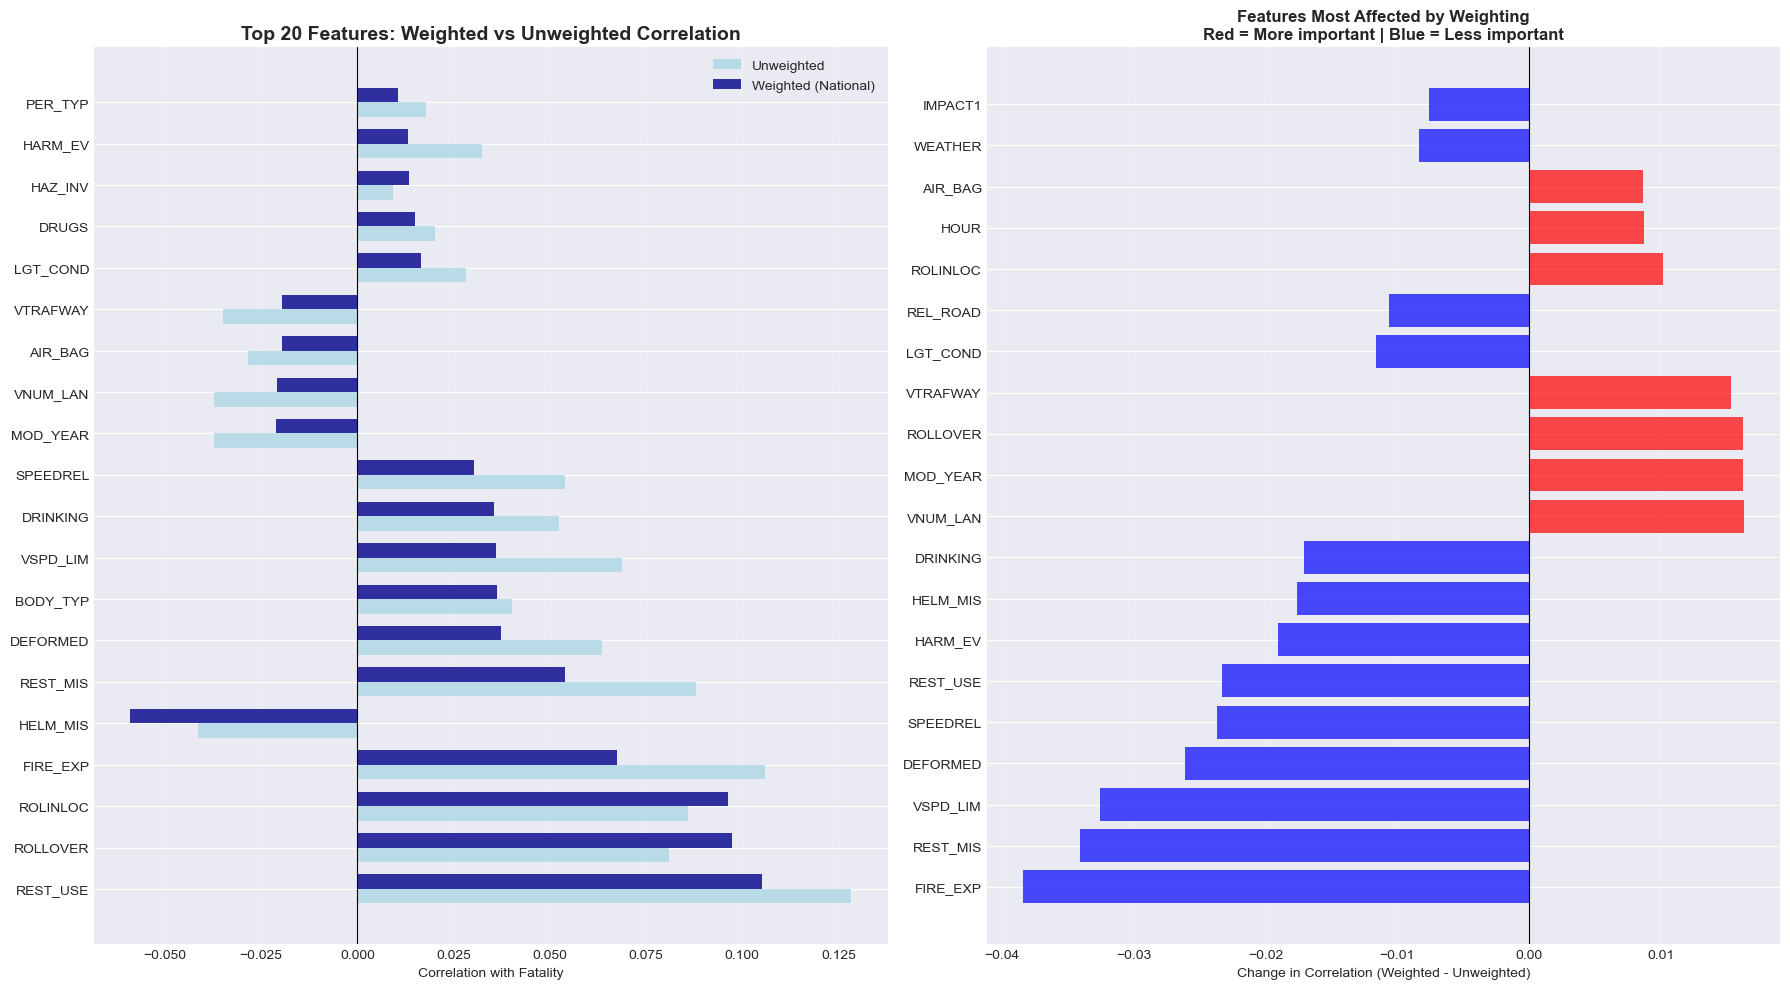

In [10]:
# Visualize correlation comparison
top_n = 20
top_features_wt = corr_comparison.head(top_n)

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Comparison plot
ax = axes[0]
x_pos = np.arange(len(top_features_wt))
width = 0.35

bars1 = ax.barh(x_pos - width/2, top_features_wt['unweighted'], width, 
               label='Unweighted', alpha=0.8, color='lightblue')
bars2 = ax.barh(x_pos + width/2, top_features_wt['weighted'], width, 
               label='Weighted (National)', alpha=0.8, color='darkblue')

ax.set_yticks(x_pos)
ax.set_yticklabels(top_features_wt.index)
ax.set_xlabel('Correlation with Fatality')
ax.set_title(f'Top {top_n} Features: Weighted vs Unweighted Correlation', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Difference plot
ax = axes[1]
# Sort by difference
top_diff = corr_comparison.iloc[:50].sort_values('difference', key=abs, ascending=False).head(20)
colors = ['red' if d > 0 else 'blue' for d in top_diff['difference']]

ax.barh(range(len(top_diff)), top_diff['difference'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_diff)))
ax.set_yticklabels(top_diff.index)
ax.set_xlabel('Change in Correlation (Weighted - Unweighted)')
ax.set_title('Features Most Affected by Weighting\nRed = More important | Blue = Less important', 
            fontsize=12, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Visualization and Correlation Plots
**Positive Correlations** (red bars):
- Higher values = MORE fatalities
- Examples: Ejection, no seatbelt, high speed
- These are **risk factors**

**Negative Correlations** (blue/green bars):
- Higher values = FEWER fatalities
- Examples: Airbag deployment, seatbelt use
- These are **protective factors**

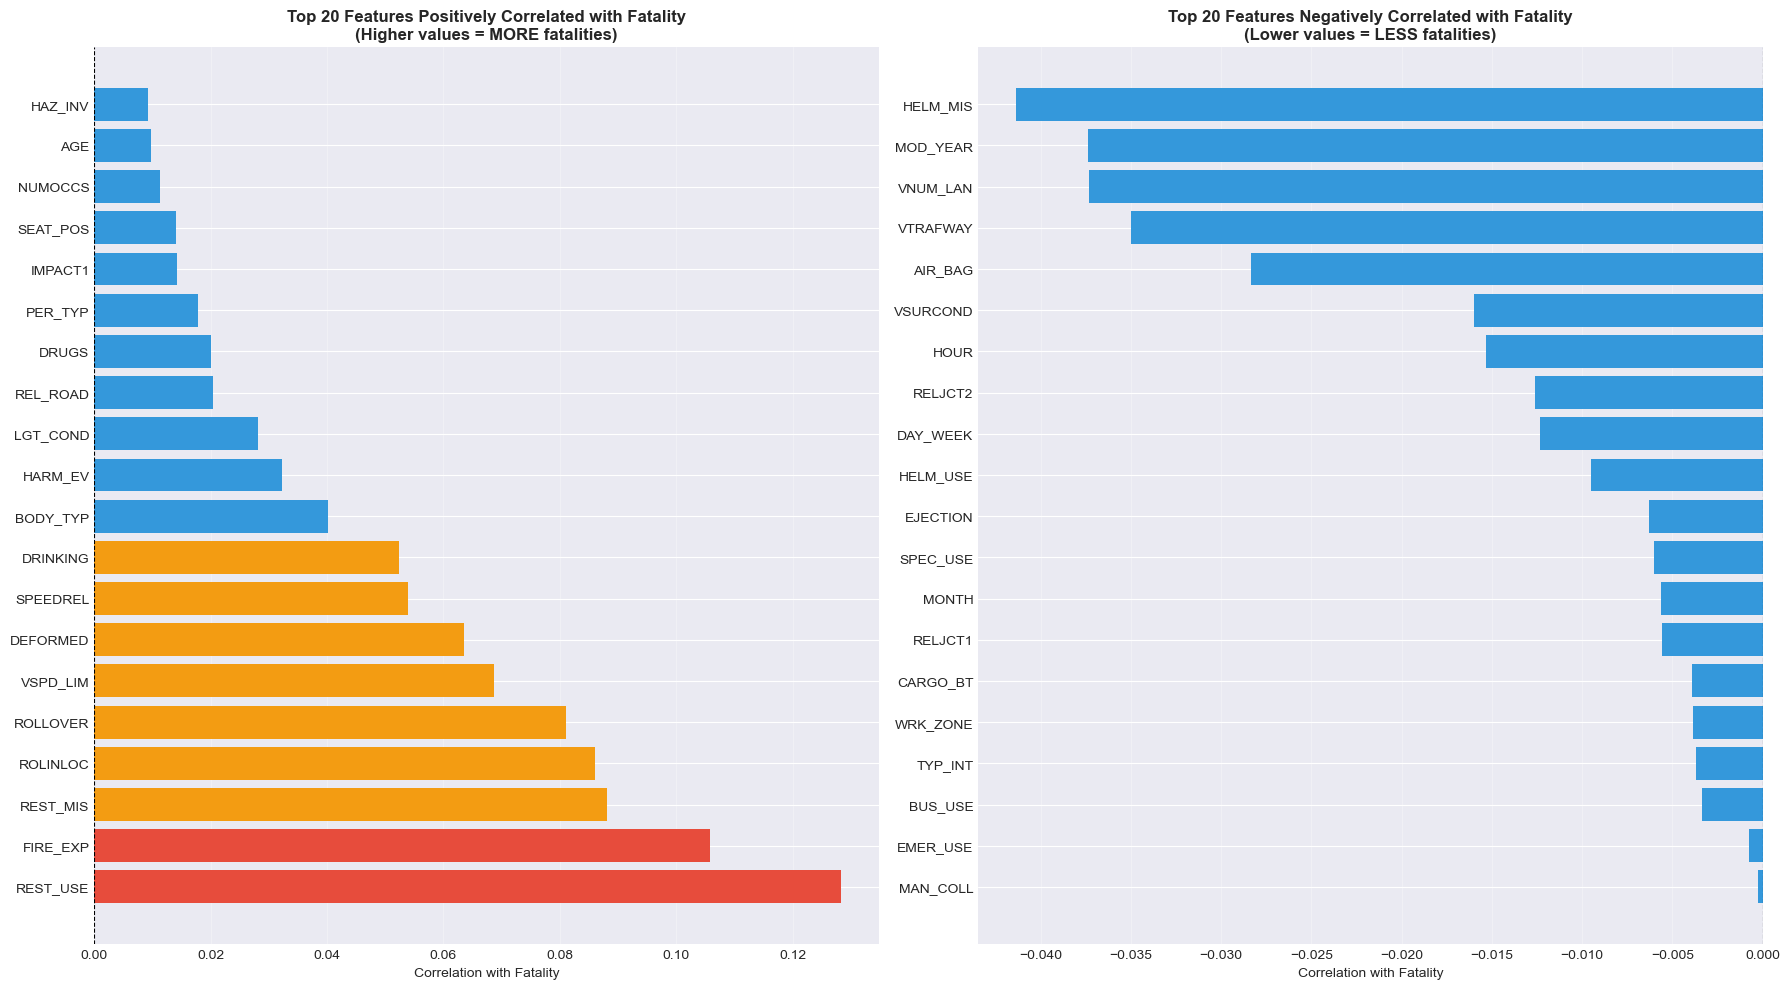

In [11]:
# Calculate correlations with target
correlations = X_clean.corrwith(y_clean).sort_values(ascending=False)
correlations_abs = correlations.abs().sort_values(ascending=False)

# Get top positive and negative correlations
top_positive = correlations.head(20)
top_negative = correlations.tail(20)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Top positive correlations
colors_pos = ['#e74c3c' if x > 0.1 else '#f39c12' if x > 0.05 else '#3498db' for x in top_positive.values]
axes[0].barh(range(len(top_positive)), top_positive.values, color=colors_pos)
axes[0].set_yticks(range(len(top_positive)))
axes[0].set_yticklabels(top_positive.index)
axes[0].set_xlabel('Correlation with Fatality')
axes[0].set_title('Top 20 Features Positively Correlated with Fatality\n(Higher values = MORE fatalities)', 
                 fontsize=12, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0].grid(axis='x', alpha=0.3)

# Top negative correlations
colors_neg = ['#2ecc71' if x < -0.05 else '#3498db' for x in top_negative.values]
axes[1].barh(range(len(top_negative)), top_negative.values, color=colors_neg)
axes[1].set_yticks(range(len(top_negative)))
axes[1].set_yticklabels(top_negative.index)
axes[1].set_xlabel('Correlation with Fatality')
axes[1].set_title('Top 20 Features Negatively Correlated with Fatality\n(Lower values = LESS fatalities)', 
                 fontsize=12, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Advanced Analysis: PCA, Modeling, and Feature Importance

### 8.0. One-Hot Encoding for Categorical Variables

Many variables are categorical (types) not continuous (amounts).

**Example:** REST_USE codes 0=None, 3=Both belts. If treated as continuous,
model incorrectly learns "higher value = worse outcome".

**Solution:** Convert categorical variables to binary indicators (one-hot encoding).


In [12]:
# Categorical variables (represent types, not amounts)
categorical_cols = [
    # Safety equipment
    'REST_USE', 'REST_MIS', 'AIR_BAG', 'HELM_USE', 'HELM_MIS',
    # Person position  
    'SEAT_POS', 'PER_TYP', 'EJECTION', 'EJ_PATH', 'EXTRICAT',
    # Substance use
    'DRINKING', 'DR_DRINK', 'DRUGS', 'DRUG_DET', 'DRUGRES1', 'DRUGRES2', 'DRUGRES3',
    # Vehicle
    'BODY_TYP', 'V_CONFIG', 'BUS_USE', 'SPEC_USE', 'EMER_USE', 'CARGO_BT', 'HAZ_INV',
    # Crash dynamics
    'ROLLOVER', 'ROLINLOC', 'FIRE_EXP', 'DEFORMED', 'IMPACT1', 'SPEEDREL',
    # Environmental
    'WEATHER', 'WEATHER1', 'WEATHER2', 'LGT_COND',
    # Roadway
    'RELJCT1', 'RELJCT2', 'TYP_INT', 'VTRAFWAY', 'VTRAFCON',
    'WRK_ZONE', 'REL_ROAD', 'FUNC_SYS', 'RUR_URB',
    'VALIGN', 'VPROFILE', 'VPAVETYP', 'VSURCOND', 'HARM_EV', 'MAN_COLL'
]

categorical_cols = [c for c in categorical_cols if c in X_clean.columns]
print(f"One-hot encoding {len(categorical_cols)} categorical variables...")
print(f"Before: {X_clean.shape}")

# Convert to string for proper categorical treatment
X_cat = X_clean.copy()
for col in categorical_cols:
    X_cat[col] = X_cat[col].astype(str)

# One-hot encode (drop_first avoids multicollinearity)
X_clean = pd.get_dummies(X_cat, columns=categorical_cols, drop_first=True)

print(f"After:  {X_clean.shape}")
print(f"Added {X_clean.shape[1] - X_cat.shape[1]} binary indicator features")


One-hot encoding 36 categorical variables...
Before: (117033, 45)
After:  (117033, 389)
Added 344 binary indicator features


### Split and prepare data

Split data into training/test sets (80/20 split) and standardize it so that the mean is 0.

In [13]:
# Split data with stratification AND WEIGHTS
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X_clean, y_clean, weights_clean,
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y_clean
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining set fatality rate: {y_train.mean():.2%}")
print(f"Test set fatality rate: {y_test.mean():.2%}")
print(f"\nTraining weighted fatality rate: {np.average(y_train, weights=weights_train):.2%}")
print(f"Test weighted fatality rate: {np.average(y_test, weights=weights_test):.2%}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nFeatures standardized (mean=0, std=1)")

Training set: (93626, 389)
Test set: (23407, 389)

Training set fatality rate: 2.15%
Test set fatality rate: 2.15%

Training weighted fatality rate: 0.56%
Test weighted fatality rate: 0.57%

Features standardized (mean=0, std=1)


### PCA 
Running PCA on data for further experimentation with logistic regression: if logistic regression can be run on the PCA components, that is a reduced data dimensionality and makes for more efficient processing.

In [14]:
# Principal Component Analysis (PCA) with Survey Weights
# PCA identifies orthogonal directions of maximum variance in the data
# This helps us understand which combinations of features explain crash outcomes

print("Fitting PCA on standardized features...")
print("Note: PCA is fit on unweighted data but results are interpreted with weights in mind")

# Initialize PCA with random state for reproducibility
pca = PCA(random_state=RANDOM_STATE)

# Fit PCA on training data (uses correlation matrix of standardized features)
pca.fit(X_train_scaled)

# Transform both training and test sets to PC space
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Extract variance explained by each component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Find number of components needed for common variance thresholds
# These thresholds tell us how many PCs we need to retain most information
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1  # 90% of variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1  # 95% of variance
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1  # 99% of variance

print(f"\nPCA Results:")
print(f"  Total components: {len(explained_variance_ratio)}")
print(f"  Components for 90% variance: {n_components_90}")
print(f"  Components for 95% variance: {n_components_95}")
print(f"  Components for 99% variance: {n_components_99}")
print(f"\nInterpretation:")
print(f"  - First {n_components_90} components capture 90% of feature variation")
print(f"  - Remaining {len(explained_variance_ratio) - n_components_90} components capture only 10%")
print(f"  - This shows we can dramatically reduce dimensionality with minimal information loss")
print(f"\nTop 5 components explain: {cumulative_variance[4]:.2%} of variance")
print(f"Top 10 components explain: {cumulative_variance[9]:.2%} of variance")


Fitting PCA on standardized features...
Note: PCA is fit on unweighted data but results are interpreted with weights in mind

PCA Results:
  Total components: 389
  Components for 90% variance: 291
  Components for 95% variance: 317
  Components for 99% variance: 347

Interpretation:
  - First 291 components capture 90% of feature variation
  - Remaining 98 components capture only 10%
  - This shows we can dramatically reduce dimensionality with minimal information loss

Top 5 components explain: 6.07% of variance
Top 10 components explain: 10.06% of variance


### Analyze PCA variance

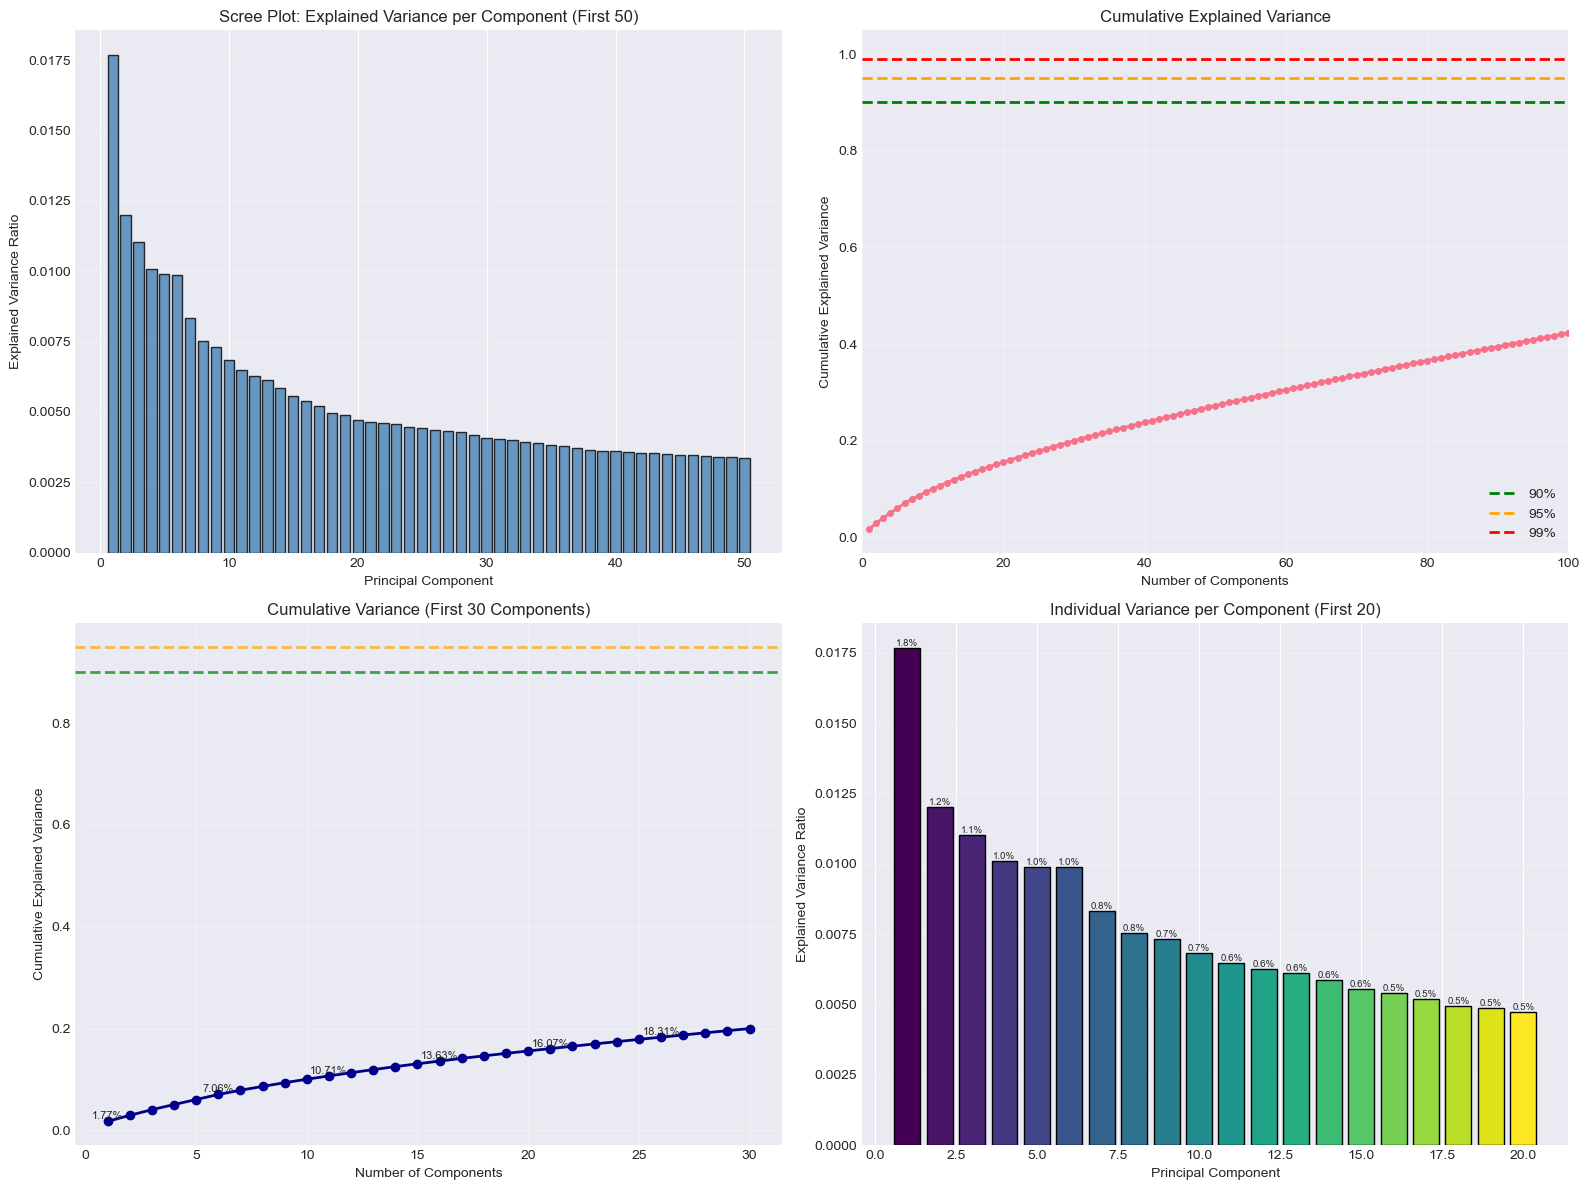

In [15]:
# Visualize explained variance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scree plot (first 50 components)
n_show = min(50, len(explained_variance_ratio))
axes[0, 0].bar(range(1, n_show + 1), explained_variance_ratio[:n_show], 
               color='steelblue', alpha=0.8, edgecolor='black')
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].set_title(f'Scree Plot: Explained Variance per Component (First {n_show})')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Cumulative explained variance
axes[0, 1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
               'o-', linewidth=2, markersize=4)
axes[0, 1].axhline(y=0.90, color='green', linestyle='--', linewidth=2, label='90%')
axes[0, 1].axhline(y=0.95, color='orange', linestyle='--', linewidth=2, label='95%')
axes[0, 1].axhline(y=0.99, color='red', linestyle='--', linewidth=2, label='99%')
axes[0, 1].axvline(x=n_components_95, color='orange', linestyle=':', alpha=0.5)
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Explained Variance')
axes[0, 1].set_title('Cumulative Explained Variance')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(0, min(100, len(cumulative_variance)))

# 3. Cumulative variance (zoomed to first 30 components)
n_zoom = min(30, len(cumulative_variance))
axes[1, 0].plot(range(1, n_zoom + 1), cumulative_variance[:n_zoom], 
               'o-', linewidth=2, markersize=6, color='darkblue')
axes[1, 0].axhline(y=0.90, color='green', linestyle='--', linewidth=2, alpha=0.7)
axes[1, 0].axhline(y=0.95, color='orange', linestyle='--', linewidth=2, alpha=0.7)
for i in range(0, n_zoom, 5):
    axes[1, 0].text(i+1, cumulative_variance[i], f'{cumulative_variance[i]:.2%}', 
                   ha='center', va='bottom', fontsize=8)
axes[1, 0].set_xlabel('Number of Components')
axes[1, 0].set_ylabel('Cumulative Explained Variance')
axes[1, 0].set_title(f'Cumulative Variance (First {n_zoom} Components)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Variance explained by each component (first 20)
n_show2 = min(20, len(explained_variance_ratio))
colors = plt.cm.viridis(np.linspace(0, 1, n_show2))
bars = axes[1, 1].bar(range(1, n_show2 + 1), explained_variance_ratio[:n_show2], 
                     color=colors, edgecolor='black')
axes[1, 1].set_xlabel('Principal Component')
axes[1, 1].set_ylabel('Explained Variance Ratio')
axes[1, 1].set_title(f'Individual Variance per Component (First {n_show2})')
axes[1, 1].grid(axis='y', alpha=0.3)
# Add percentage labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height*100:.1f}%', ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.show()

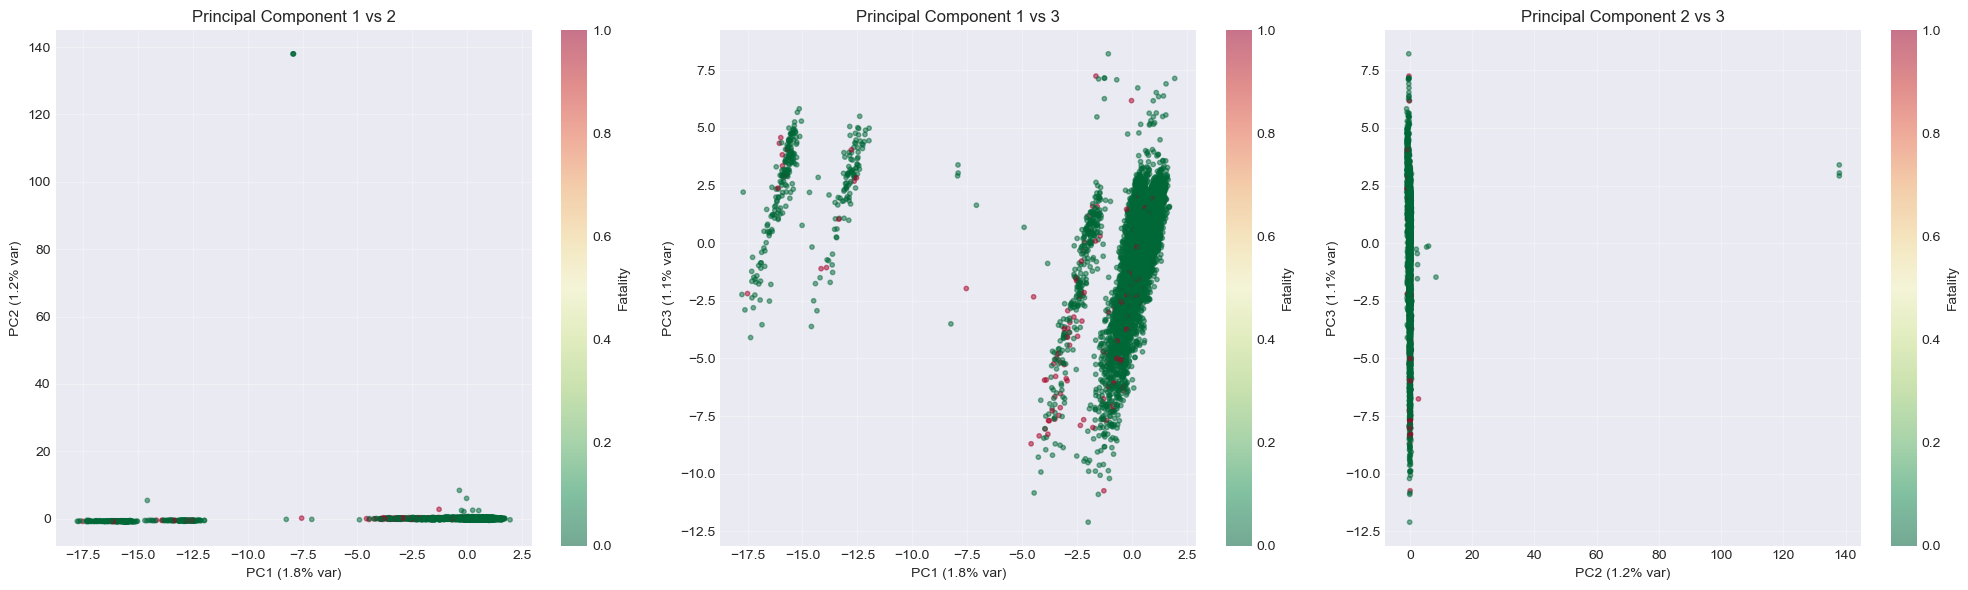

In [16]:
# Visualize data in PC space
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Sample for visualization (if dataset is large)
n_sample = min(10000, len(X_train_pca))
sample_idx = np.random.choice(len(X_train_pca), n_sample, replace=False)

X_sample = X_train_pca[sample_idx]
y_sample = y_train.iloc[sample_idx]

# PC1 vs PC2
scatter1 = axes[0].scatter(X_sample[:, 0], X_sample[:, 1], 
                          c=y_sample, cmap='RdYlGn_r', alpha=0.5, s=10)
axes[0].set_xlabel(f'PC1 ({explained_variance_ratio[0]*100:.1f}% var)')
axes[0].set_ylabel(f'PC2 ({explained_variance_ratio[1]*100:.1f}% var)')
axes[0].set_title('Principal Component 1 vs 2')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Fatality')

# PC1 vs PC3
scatter2 = axes[1].scatter(X_sample[:, 0], X_sample[:, 2], 
                          c=y_sample, cmap='RdYlGn_r', alpha=0.5, s=10)
axes[1].set_xlabel(f'PC1 ({explained_variance_ratio[0]*100:.1f}% var)')
axes[1].set_ylabel(f'PC3 ({explained_variance_ratio[2]*100:.1f}% var)')
axes[1].set_title('Principal Component 1 vs 3')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Fatality')

# PC2 vs PC3
scatter3 = axes[2].scatter(X_sample[:, 1], X_sample[:, 2], 
                          c=y_sample, cmap='RdYlGn_r', alpha=0.5, s=10)
axes[2].set_xlabel(f'PC2 ({explained_variance_ratio[1]*100:.1f}% var)')
axes[2].set_ylabel(f'PC3 ({explained_variance_ratio[2]*100:.1f}% var)')
axes[2].set_title('Principal Component 2 vs 3')
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[2], label='Fatality')

plt.tight_layout()
plt.show()

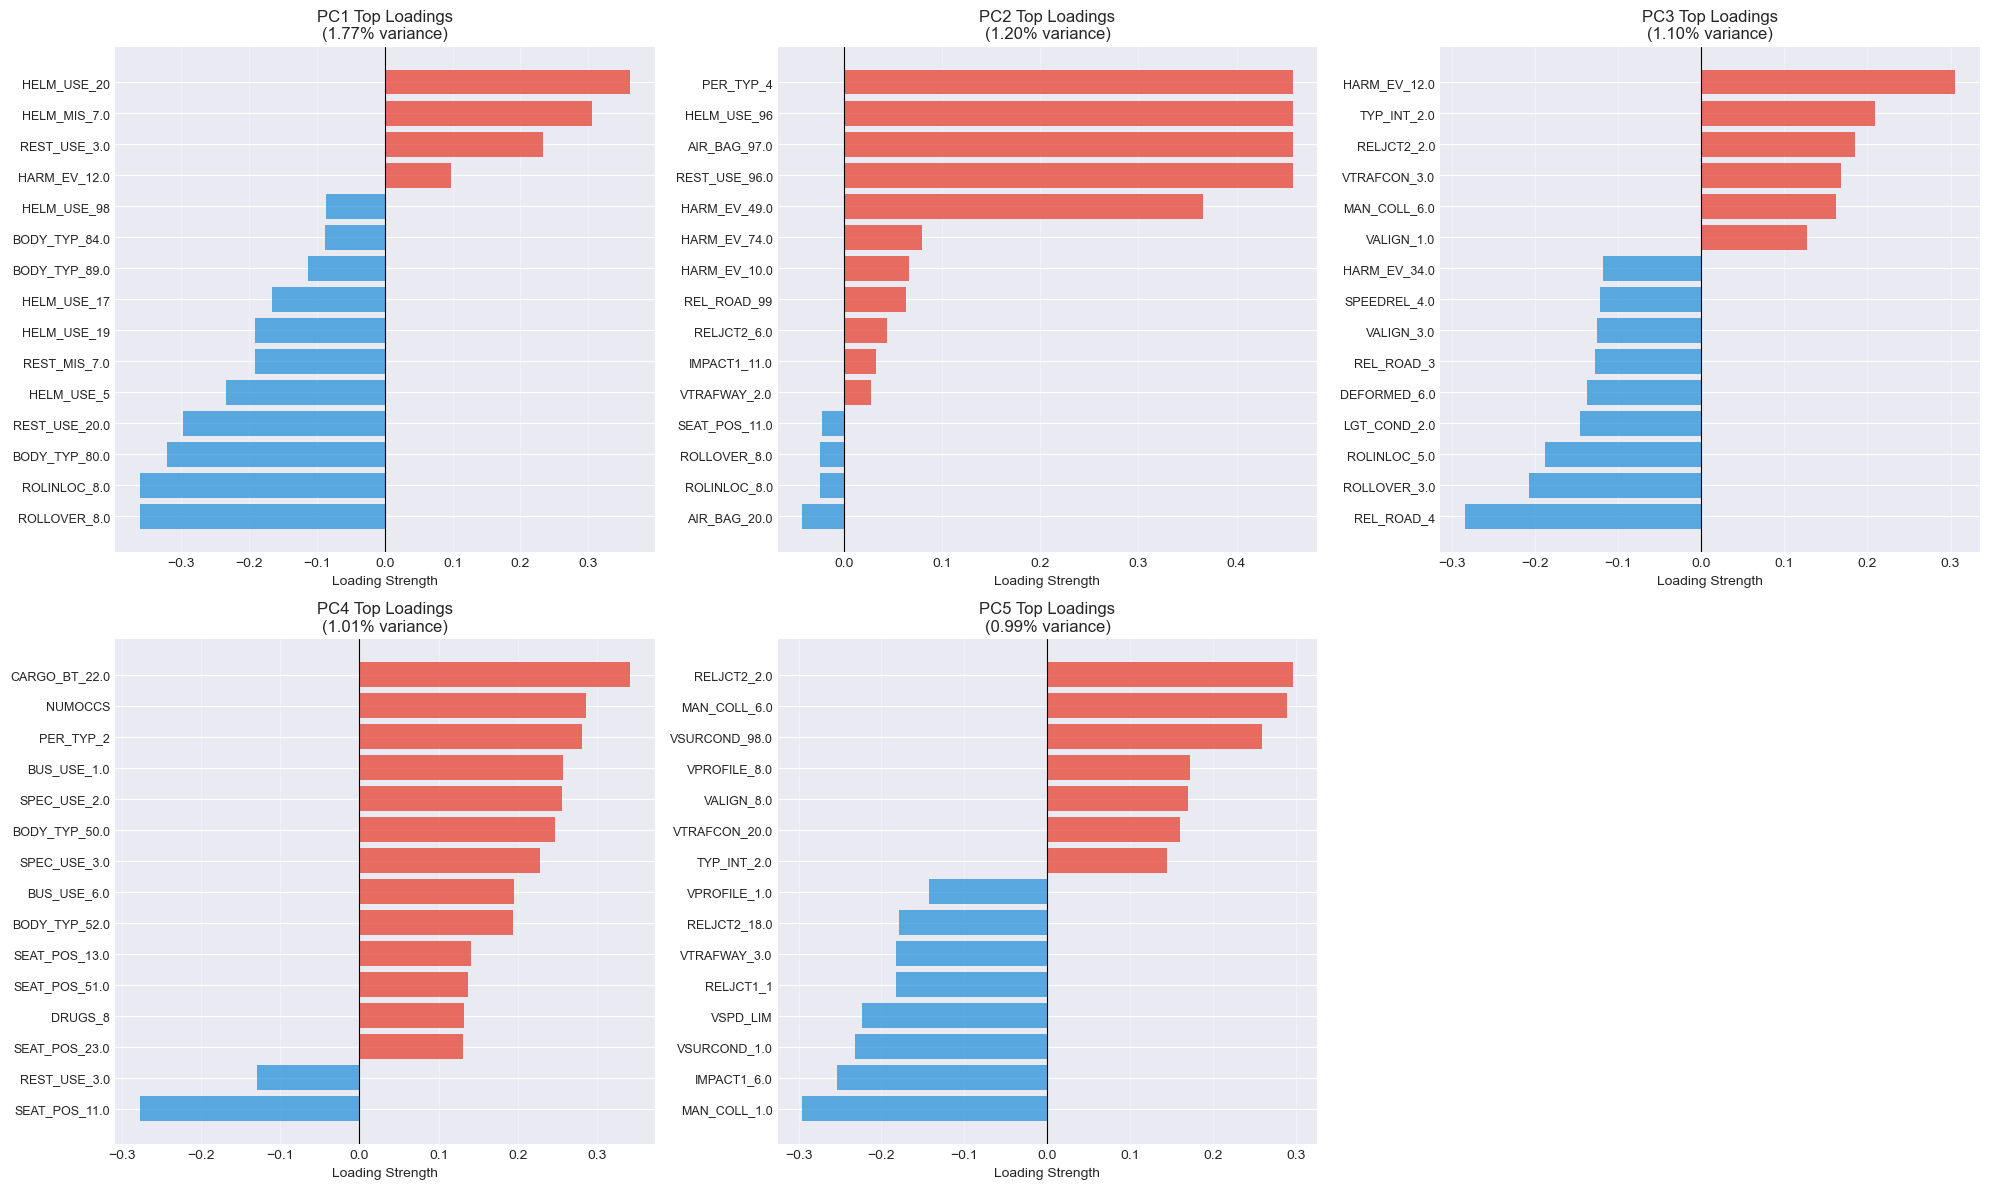


PRINCIPAL COMPONENT LOADINGS

PC1 (1.77% variance):
  Top 10 features:
     1. HELM_USE_20         :  0.3619 (positive)
     2. ROLLOVER_8.0        : -0.3612 (negative)
     3. ROLINLOC_8.0        : -0.3612 (negative)
     4. BODY_TYP_80.0       : -0.3213 (negative)
     5. HELM_MIS_7.0        :  0.3056 (positive)
     6. REST_USE_20.0       : -0.2975 (negative)
     7. HELM_USE_5          : -0.2340 (negative)
     8. REST_USE_3.0        :  0.2326 (positive)
     9. REST_MIS_7.0        : -0.1908 (negative)
    10. HELM_USE_19         : -0.1906 (negative)

PC2 (1.20% variance):
  Top 10 features:
     1. PER_TYP_4           :  0.4574 (positive)
     2. HELM_USE_96         :  0.4574 (positive)
     3. AIR_BAG_97.0        :  0.4574 (positive)
     4. REST_USE_96.0       :  0.4574 (positive)
     5. HARM_EV_49.0        :  0.3660 (positive)
     6. HARM_EV_74.0        :  0.0796 (positive)
     7. HARM_EV_10.0        :  0.0665 (positive)
     8. REL_ROAD_99         :  0.0634 (positive)
    

In [17]:
# Analyze component loadings
n_components_to_analyze = min(5, len(pca.components_))

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i in range(n_components_to_analyze):
    loadings = pca.components_[i]
    
    # Get top 15 features by absolute loading
    top_idx = np.argsort(np.abs(loadings))[-15:]
    top_features = X_train.columns[top_idx]
    top_loadings = loadings[top_idx]
    
    # Sort by loading value
    sort_idx = np.argsort(top_loadings)
    top_features = top_features[sort_idx]
    top_loadings = top_loadings[sort_idx]
    
    # Color by sign
    colors = ['#e74c3c' if x > 0 else '#3498db' for x in top_loadings]
    
    axes[i].barh(range(len(top_features)), top_loadings, color=colors, alpha=0.8)
    axes[i].set_yticks(range(len(top_features)))
    axes[i].set_yticklabels(top_features, fontsize=9)
    axes[i].set_xlabel('Loading Strength')
    axes[i].set_title(f'PC{i+1} Top Loadings\n({explained_variance_ratio[i]*100:.2f}% variance)')
    axes[i].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[i].grid(axis='x', alpha=0.3)

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Print loadings details
print("\n" + "="*80)
print("PRINCIPAL COMPONENT LOADINGS")
print("="*80)
for i in range(n_components_to_analyze):
    loadings = pca.components_[i]
    top_idx = np.argsort(np.abs(loadings))[-10:][::-1]
    
    print(f"\nPC{i+1} ({explained_variance_ratio[i]*100:.2f}% variance):")
    print("  Top 10 features:")
    for j, idx in enumerate(top_idx, 1):
        feature = X_train.columns[idx]
        loading = loadings[idx]
        direction = "positive" if loading > 0 else "negative"
        print(f"    {j:2d}. {feature:20s}: {loading:7.4f} ({direction})")

### Logistic regression on the original features (non-PCA)

In [18]:
# Train logistic regression on original features WITH SURVEY WEIGHTS
print("Training Logistic Regression on ORIGINAL features WITH SURVEY WEIGHTS...\n")

# Use regularization to handle high dimensionality
lr_original = LogisticRegressionCV(
    cv=5,
    penalty='l2',
    scoring='roc_auc',
    max_iter=1000,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# FIT WITH SAMPLE WEIGHTS (survey weights)
lr_original.fit(X_train_scaled, y_train, sample_weight=weights_train)

# Predictions
y_pred_orig = lr_original.predict(X_test_scaled)
y_pred_proba_orig = lr_original.predict_proba(X_test_scaled)[:, 1]

# Metrics (weighted)
roc_auc_orig = roc_auc_score(y_test, y_pred_proba_orig, sample_weight=weights_test)

print("\n" + "="*80)
print("LOGISTIC REGRESSION (Original Features) - SURVEY WEIGHTED")
print("="*80)
print(f"\nROC-AUC Score (weighted): {roc_auc_orig:.4f}")
print(f"Best C parameter: {lr_original.C_[0]:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_orig, target_names=['No Fatality', 'Fatality'], sample_weight=weights_test))

Training Logistic Regression on ORIGINAL features WITH SURVEY WEIGHTS...


LOGISTIC REGRESSION (Original Features) - SURVEY WEIGHTED

ROC-AUC Score (weighted): 0.9130
Best C parameter: 0.0001

Classification Report:
              precision    recall  f1-score   support

 No Fatality       0.99      1.00      1.00 2857051.015693247
    Fatality       0.53      0.06      0.11 16403.767588538984

    accuracy                           0.99 2873454.783281786
   macro avg       0.76      0.53      0.55 2873454.783281786
weighted avg       0.99      0.99      0.99 2873454.783281786



## Logistic Regression on PCA Components

For comparison with Logistic regression on the original data, trying to see if they have comparable accuracy - using the PCA components instead would have reduced dimensionality.

**Warning:** This cell takes quite a few minutes to run. Only the following cell if dependent on the variables/results, so if looking for specific regression results you can skip running this for the sake of time.

In [19]:
# Train multiple logistic regression variants on PCA components
print("Training Logistic Regression variants on PCA components...\n")

# Use 95% variance threshold
X_train_pca_subset = X_train_pca[:, :n_components_95]
X_test_pca_subset = X_test_pca[:, :n_components_95]

print(f"Using {n_components_95} principal components (95% variance)\n")

# Define models
pca_models = {
    'L2 (Ridge)': LogisticRegression(
        penalty='l2', 
        C=1.0, 
        solver='lbfgs', 
        max_iter=1000, 
        random_state=RANDOM_STATE
    ),
    'L1 (Lasso)': LogisticRegression(
        penalty='l1', 
        C=1.0, 
        solver='saga', 
        max_iter=1000, 
        random_state=RANDOM_STATE
    ),
    'Elastic Net': LogisticRegression(
        penalty='elasticnet', 
        C=1.0, 
        l1_ratio=0.5, 
        solver='saga', 
        max_iter=1000, 
        random_state=RANDOM_STATE
    ),
    'No Penalty': LogisticRegression(
        penalty=None,
        solver='lbfgs',
        max_iter=1000,
        random_state=RANDOM_STATE
    )
}

# Train and evaluate each model
pca_results = {}

for name, model in pca_models.items():
    print(f"Training {name}...")
    model.fit(X_train_pca_subset, y_train)
    
    y_pred = model.predict(X_test_pca_subset)
    y_pred_proba = model.predict_proba(X_test_pca_subset)[:, 1]
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    pca_results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'roc_auc': roc_auc
    }
    
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print()

# Print detailed results
print("\n" + "="*80)
print("LOGISTIC REGRESSION RESULTS (PCA Components)")
print("="*80)

for name, results in pca_results.items():
    print(f"\n{'='*40}")
    print(f"{name}")
    print(f"{'='*40}")
    print(f"ROC-AUC Score: {results['roc_auc']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, results['y_pred'], 
                               target_names=['No Fatality', 'Fatality']))

Training Logistic Regression variants on PCA components...

Using 317 principal components (95% variance)

Training L2 (Ridge)...
  ROC-AUC: 0.8691

Training L1 (Lasso)...
  ROC-AUC: 0.8632

Training Elastic Net...
  ROC-AUC: 0.8632

Training No Penalty...
  ROC-AUC: 0.8691


LOGISTIC REGRESSION RESULTS (PCA Components)

L2 (Ridge)
ROC-AUC Score: 0.8691

Classification Report:
              precision    recall  f1-score   support

 No Fatality       0.98      1.00      0.99     22904
    Fatality       0.54      0.09      0.16       503

    accuracy                           0.98     23407
   macro avg       0.76      0.55      0.57     23407
weighted avg       0.97      0.98      0.97     23407


L1 (Lasso)
ROC-AUC Score: 0.8632

Classification Report:
              precision    recall  f1-score   support

 No Fatality       0.98      1.00      0.99     22904
    Fatality       0.51      0.09      0.15       503

    accuracy                           0.98     23407
   macro avg     

### Compare model run on PCA to original data 

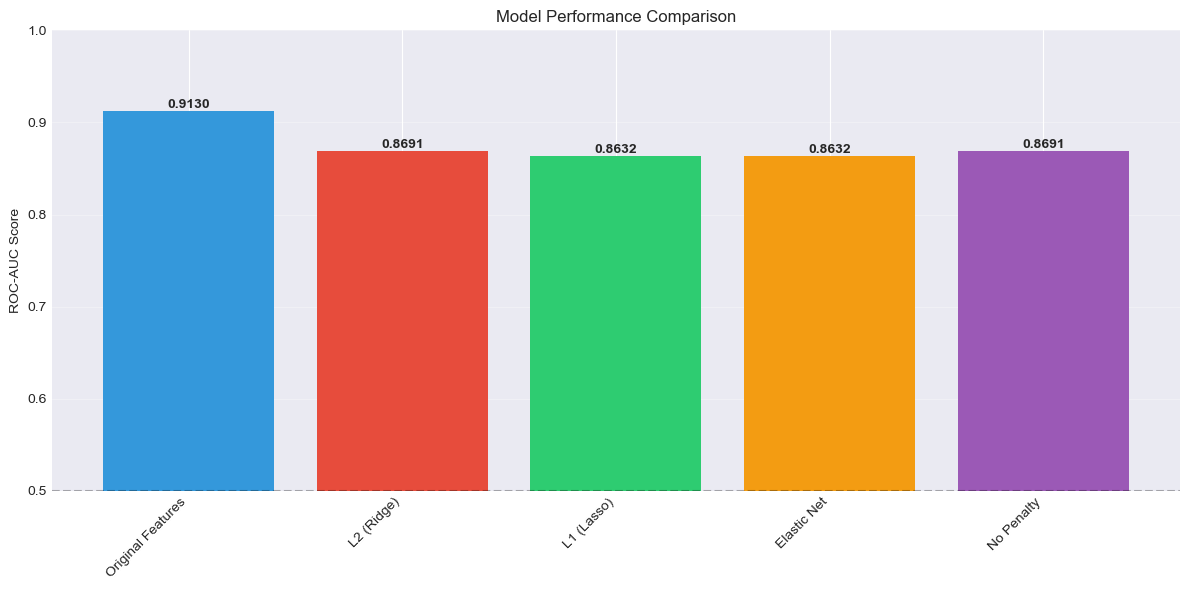


Model Comparison:
            Model  ROC-AUC
Original Features 0.912978
       L2 (Ridge) 0.869062
       L1 (Lasso) 0.863154
      Elastic Net 0.863204
       No Penalty 0.869116


In [20]:
# Compare all models
model_comparison = pd.DataFrame({
    'Model': ['Original Features'] + list(pca_results.keys()),
    'ROC-AUC': [roc_auc_orig] + [r['roc_auc'] for r in pca_results.values()]
})

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(model_comparison['Model'], model_comparison['ROC-AUC'], 
             color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'])
ax.set_ylabel('ROC-AUC Score')
ax.set_title('Model Performance Comparison')
ax.set_ylim(0.5, 1.0)
ax.axhline(y=0.5, color='black', linestyle='--', alpha=0.3, label='Random')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nModel Comparison:")
print(model_comparison.to_string(index=False))

## Assess Coefficient magnitude (Influence on fatality outcome)

Note that to best understand this, the CRSS User manual provides information on the meaning of each variable

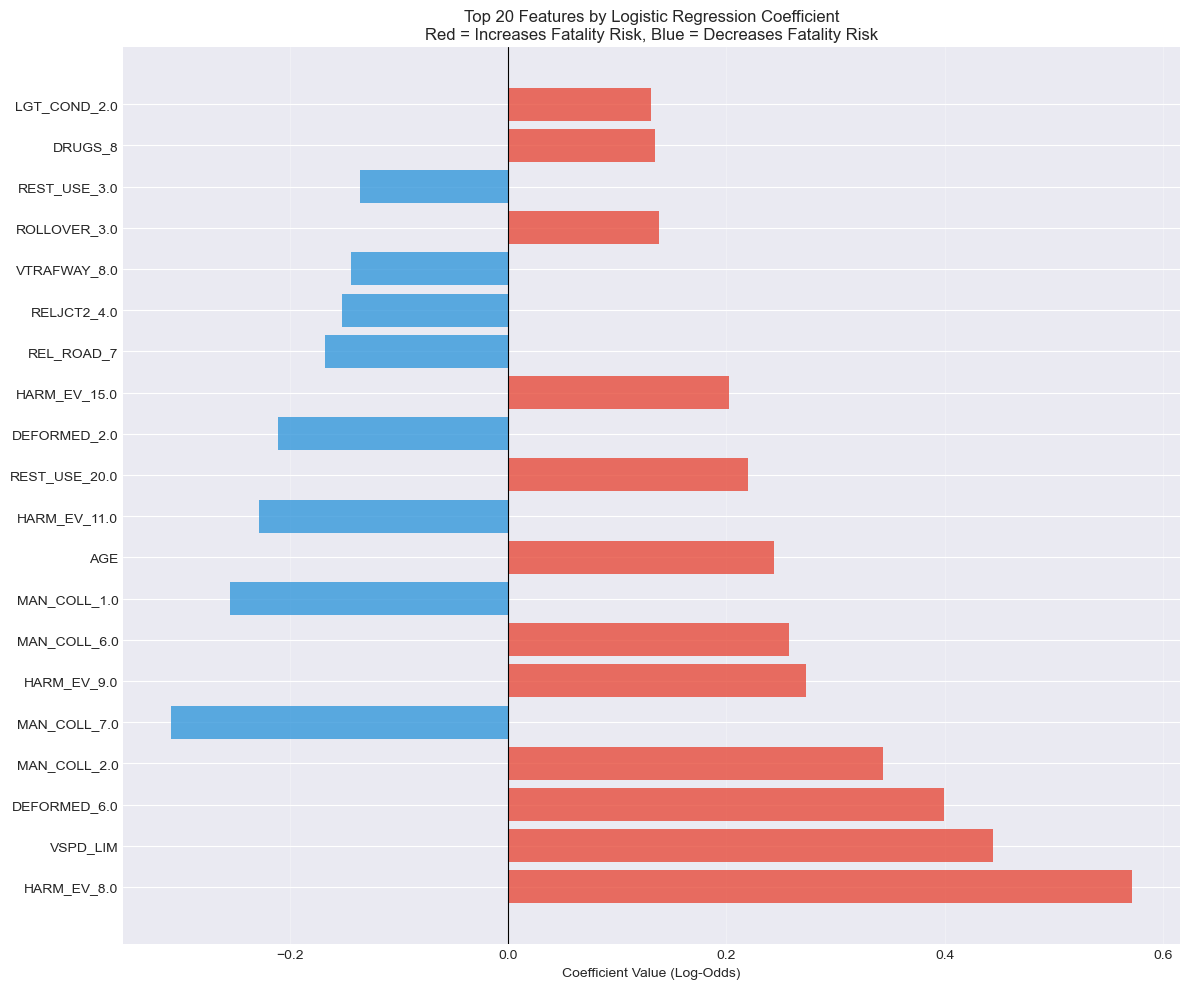


TOP 30 FEATURES BY COEFFICIENT MAGNITUDE

Positive coefficients INCREASE fatality risk
Negative coefficients DECREASE fatality risk

HARM_EV_8.0              :   0.5714 (↑ increases risk)
VSPD_LIM                 :   0.4440 (↑ increases risk)
DEFORMED_6.0             :   0.3992 (↑ increases risk)
MAN_COLL_2.0             :   0.3438 (↑ increases risk)
MAN_COLL_7.0             :  -0.3084 (↓ decreases risk)
HARM_EV_9.0              :   0.2732 (↑ increases risk)
MAN_COLL_6.0             :   0.2574 (↑ increases risk)
MAN_COLL_1.0             :  -0.2546 (↓ decreases risk)
AGE                      :   0.2432 (↑ increases risk)
HARM_EV_11.0             :  -0.2280 (↓ decreases risk)
REST_USE_20.0            :   0.2199 (↑ increases risk)
DEFORMED_2.0             :  -0.2102 (↓ decreases risk)
HARM_EV_15.0             :   0.2025 (↑ increases risk)
REL_ROAD_7               :  -0.1674 (↓ decreases risk)
RELJCT2_4.0              :  -0.1520 (↓ decreases risk)
VTRAFWAY_8.0             :  -0.1433 (↓ de

In [21]:
# Get coefficients from best logistic regression model (original data)
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_original.coef_[0]
})

# Sort by absolute value
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients_sorted = coefficients.sort_values('Abs_Coefficient', ascending=False)

# Plot top 20 features
top_n = 20
top_features = coefficients_sorted.head(top_n)

fig, ax = plt.subplots(figsize=(12, 10))
colors = ['#e74c3c' if x > 0 else '#3498db' for x in top_features['Coefficient']]
ax.barh(range(top_n), top_features['Coefficient'], color=colors, alpha=0.8)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Coefficient Value (Log-Odds)')
ax.set_title(f'Top {top_n} Features by Logistic Regression Coefficient\n' +
            'Red = Increases Fatality Risk, Blue = Decreases Fatality Risk')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print top features
print("\n" + "="*80)
print("TOP 30 FEATURES BY COEFFICIENT MAGNITUDE")
print("="*80)
print("\nPositive coefficients INCREASE fatality risk")
print("Negative coefficients DECREASE fatality risk\n")
for i, row in coefficients_sorted.head(30).iterrows():
    effect = "↑ increases" if row['Coefficient'] > 0 else "↓ decreases"
    print(f"{row['Feature']:25s}: {row['Coefficient']:8.4f} ({effect} risk)")

Calculating WEIGHTED permutation importance with confidence intervals...

This may take a few minutes...

Computing weighted permutation importance...


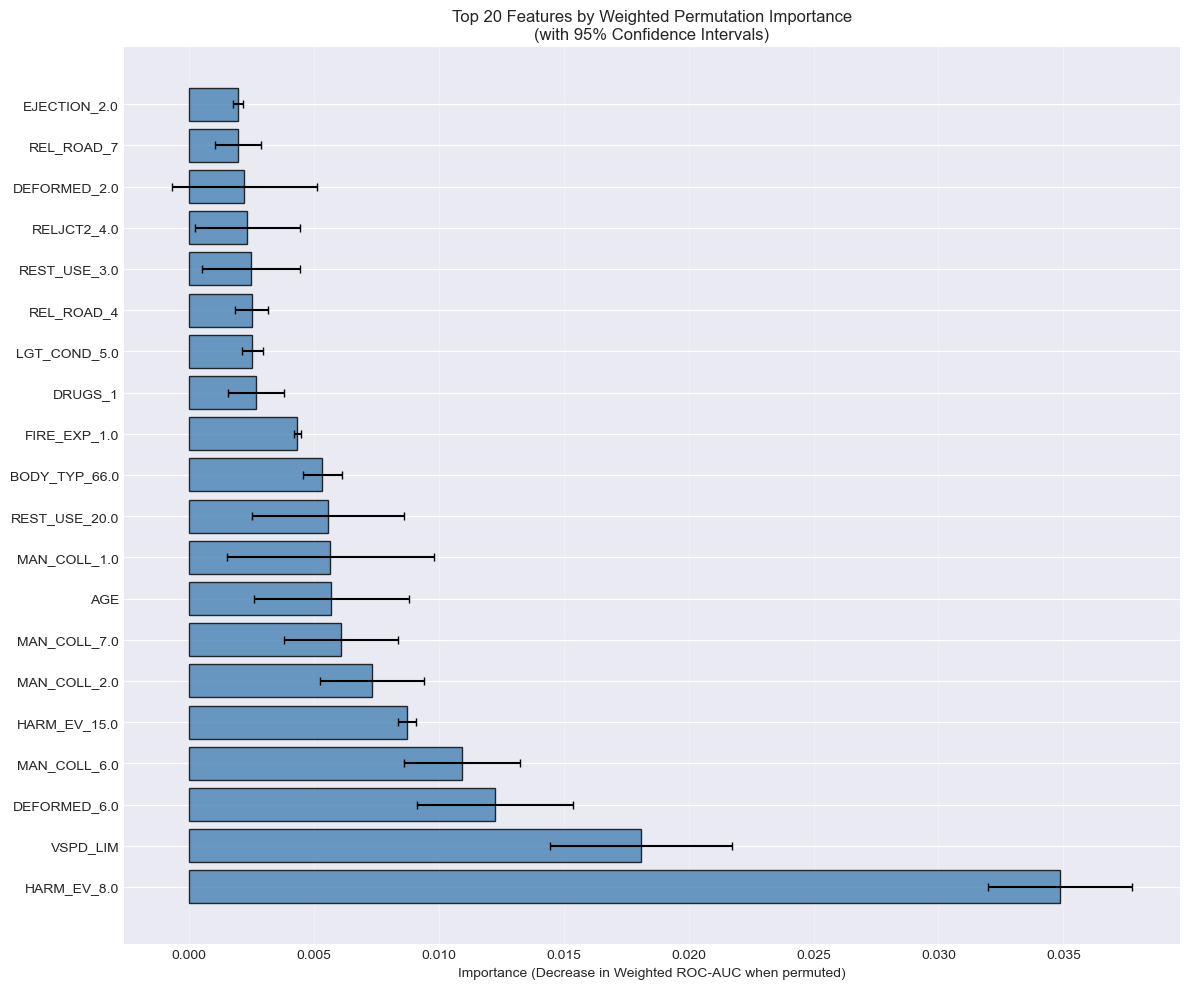


TOP 30 FEATURES BY WEIGHTED PERMUTATION IMPORTANCE

Higher importance = more critical for model predictions
95% Confidence Intervals shown

 1. HARM_EV_8.0              : 0.034856 (CI: [0.029192, 0.040520])
 2. VSPD_LIM                 : 0.018097 (CI: [0.010944, 0.025251])
 3. DEFORMED_6.0             : 0.012261 (CI: [0.006146, 0.018375])
 4. MAN_COLL_6.0             : 0.010917 (CI: [0.006363, 0.015471])
 5. HARM_EV_15.0             : 0.008732 (CI: [0.008042, 0.009422])
 6. MAN_COLL_2.0             : 0.007330 (CI: [0.003235, 0.011425])
 7. MAN_COLL_7.0             : 0.006090 (CI: [0.001622, 0.010558])
 8. AGE                      : 0.005703 (CI: [-0.000374, 0.011780])
 9. MAN_COLL_1.0             : 0.005667 (CI: [-0.002473, 0.013807])
10. REST_USE_20.0            : 0.005568 (CI: [-0.000362, 0.011499])
11. BODY_TYP_66.0            : 0.005345 (CI: [0.003786, 0.006904])
12. FIRE_EXP_1.0             : 0.004335 (CI: [0.004068, 0.004602])
13. DRUGS_1                  : 0.002689 (CI: [0.0004

In [22]:
# Calculate permutation importance (more reliable than coefficients) WITH WEIGHTS
print("Calculating WEIGHTED permutation importance with confidence intervals...\n")
print("This may take a few minutes...\n")

# Use a sample for faster computation
n_sample_perm = min(5000, len(X_test_scaled))
sample_idx = np.random.choice(len(X_test_scaled), n_sample_perm, replace=False)
X_test_sample = X_test_scaled.iloc[sample_idx]
y_test_sample = y_test.iloc[sample_idx]
weights_test_sample = weights_test.iloc[sample_idx]

# Create custom scorer that uses sample weights
# For proper weighted permutation importance, we compute it manually
from sklearn.utils import check_random_state

def weighted_permutation_importance(estimator, X, y, sample_weight, n_repeats=10, random_state=None):
    """Calculate permutation importance with sample weights"""
    rng = check_random_state(random_state)
    
    # Baseline score (with weights)
    y_pred_proba = estimator.predict_proba(X)[:, 1]
    baseline_score = roc_auc_score(y, y_pred_proba, sample_weight=sample_weight)
    
    # Calculate importance for each feature
    importances = np.zeros((X.shape[1], n_repeats))
    
    for feature_idx in range(X.shape[1]):
        for repeat_idx in range(n_repeats):
            # Permute feature
            X_permuted = X.copy()
            X_permuted.iloc[:, feature_idx] = rng.permutation(X_permuted.iloc[:, feature_idx])
            
            # Calculate permuted score (with weights)
            y_pred_proba_permuted = estimator.predict_proba(X_permuted)[:, 1]
            permuted_score = roc_auc_score(y, y_pred_proba_permuted, sample_weight=sample_weight)
            
            # Importance is decrease in score
            importances[feature_idx, repeat_idx] = baseline_score - permuted_score
    
    return importances

print("Computing weighted permutation importance...")
importances = weighted_permutation_importance(
    lr_original,
    X_test_sample,
    y_test_sample,
    weights_test_sample,
    n_repeats=10,
    random_state=RANDOM_STATE
)

# Create dataframe with confidence intervals
perm_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances.mean(axis=1),
    'Std': importances.std(axis=1),
    'CI_lower': importances.mean(axis=1) - 1.96 * importances.std(axis=1),
    'CI_upper': importances.mean(axis=1) + 1.96 * importances.std(axis=1)
}).sort_values('Importance', ascending=False)

# Plot top 20
top_n = 20
top_perm = perm_importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(12, 10))
ax.barh(range(top_n), top_perm['Importance'], xerr=top_perm['Std'],
       color='steelblue', alpha=0.8, edgecolor='black', capsize=3)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_perm['Feature'])
ax.set_xlabel('Importance (Decrease in Weighted ROC-AUC when permuted)')
ax.set_title(f'Top {top_n} Features by Weighted Permutation Importance\n(with 95% Confidence Intervals)')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("TOP 30 FEATURES BY WEIGHTED PERMUTATION IMPORTANCE")
print("="*80)
print("\nHigher importance = more critical for model predictions")
print("95% Confidence Intervals shown\n")
for i, (idx, row) in enumerate(perm_importance_df.head(30).iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:25s}: {row['Importance']:.6f} (CI: [{row['CI_lower']:.6f}, {row['CI_upper']:.6f}])")

### For interpretation, measuring grouped features influence on fatality outcomes

In [23]:
# Calculate category-level importance
category_importance = {}

for cat_name, cat_info in FEATURE_CATEGORIES.items():
    # Get features in this category that are in our model
    cat_features = [f for f in cat_info['columns'] if f in X_train.columns]
    
    if len(cat_features) == 0:
        continue
    
    # Sum of absolute coefficients
    cat_coef_sum = coefficients[coefficients['Feature'].isin(cat_features)]['Abs_Coefficient'].sum()
    
    # Average permutation importance
    cat_perm_mean = perm_importance_df[perm_importance_df['Feature'].isin(cat_features)]['Importance'].mean()
    cat_perm_sum = perm_importance_df[perm_importance_df['Feature'].isin(cat_features)]['Importance'].sum()
    
    # Average absolute correlation
    cat_corr_mean = correlations_abs[cat_features].mean()
    
    category_importance[cat_name] = {
        'n_features': len(cat_features),
        'coef_sum': cat_coef_sum,
        'perm_mean': cat_perm_mean,
        'perm_sum': cat_perm_sum,
        'corr_mean': cat_corr_mean,
        'description': cat_info['description']
    }

# Create dataframe
category_df = pd.DataFrame(category_importance).T
category_df = category_df.sort_values('perm_sum', ascending=False)

print("\n" + "="*80)
print("FEATURE CATEGORY IMPORTANCE SUMMARY")
print("="*80)
print("\nRanked by total permutation importance:\n")
for idx, row in category_df.iterrows():
    print(f"{idx.upper()}:")
    print(f"  Description: {row['description']}")
    print(f"  Features used: {int(row['n_features'])}")
    print(f"  Total coefficient magnitude: {row['coef_sum']:.4f}")
    print(f"  Avg permutation importance: {row['perm_mean']:.6f}")
    print(f"  Total permutation importance: {row['perm_sum']:.6f}")
    print(f"  Avg abs correlation: {row['corr_mean']:.4f}")
    print()


FEATURE CATEGORY IMPORTANCE SUMMARY

Ranked by total permutation importance:

SPEED_BEHAVIOR:
  Description: Speed-related factors
  Features used: 1
  Total coefficient magnitude: 0.4440
  Avg permutation importance: 0.018097
  Total permutation importance: 0.018097
  Avg abs correlation: 0.0687

DEMOGRAPHICS:
  Description: Person demographics
  Features used: 1
  Total coefficient magnitude: 0.2432
  Avg permutation importance: 0.005703
  Total permutation importance: 0.005703
  Avg abs correlation: 0.0098

ROADWAY:
  Description: Road type, junction, traffic control
  Features used: 1
  Total coefficient magnitude: 0.0663
  Avg permutation importance: 0.000835
  Total permutation importance: 0.000835
  Avg abs correlation: 0.0373

CRASH_DYNAMICS:
  Description: Impact, fire, rollover
  Features used: 1
  Total coefficient magnitude: 0.1235
  Avg permutation importance: 0.000335
  Total permutation importance: 0.000335
  Avg abs correlation: 0.0113

VEHICLE_TYPE:
  Description: Veh

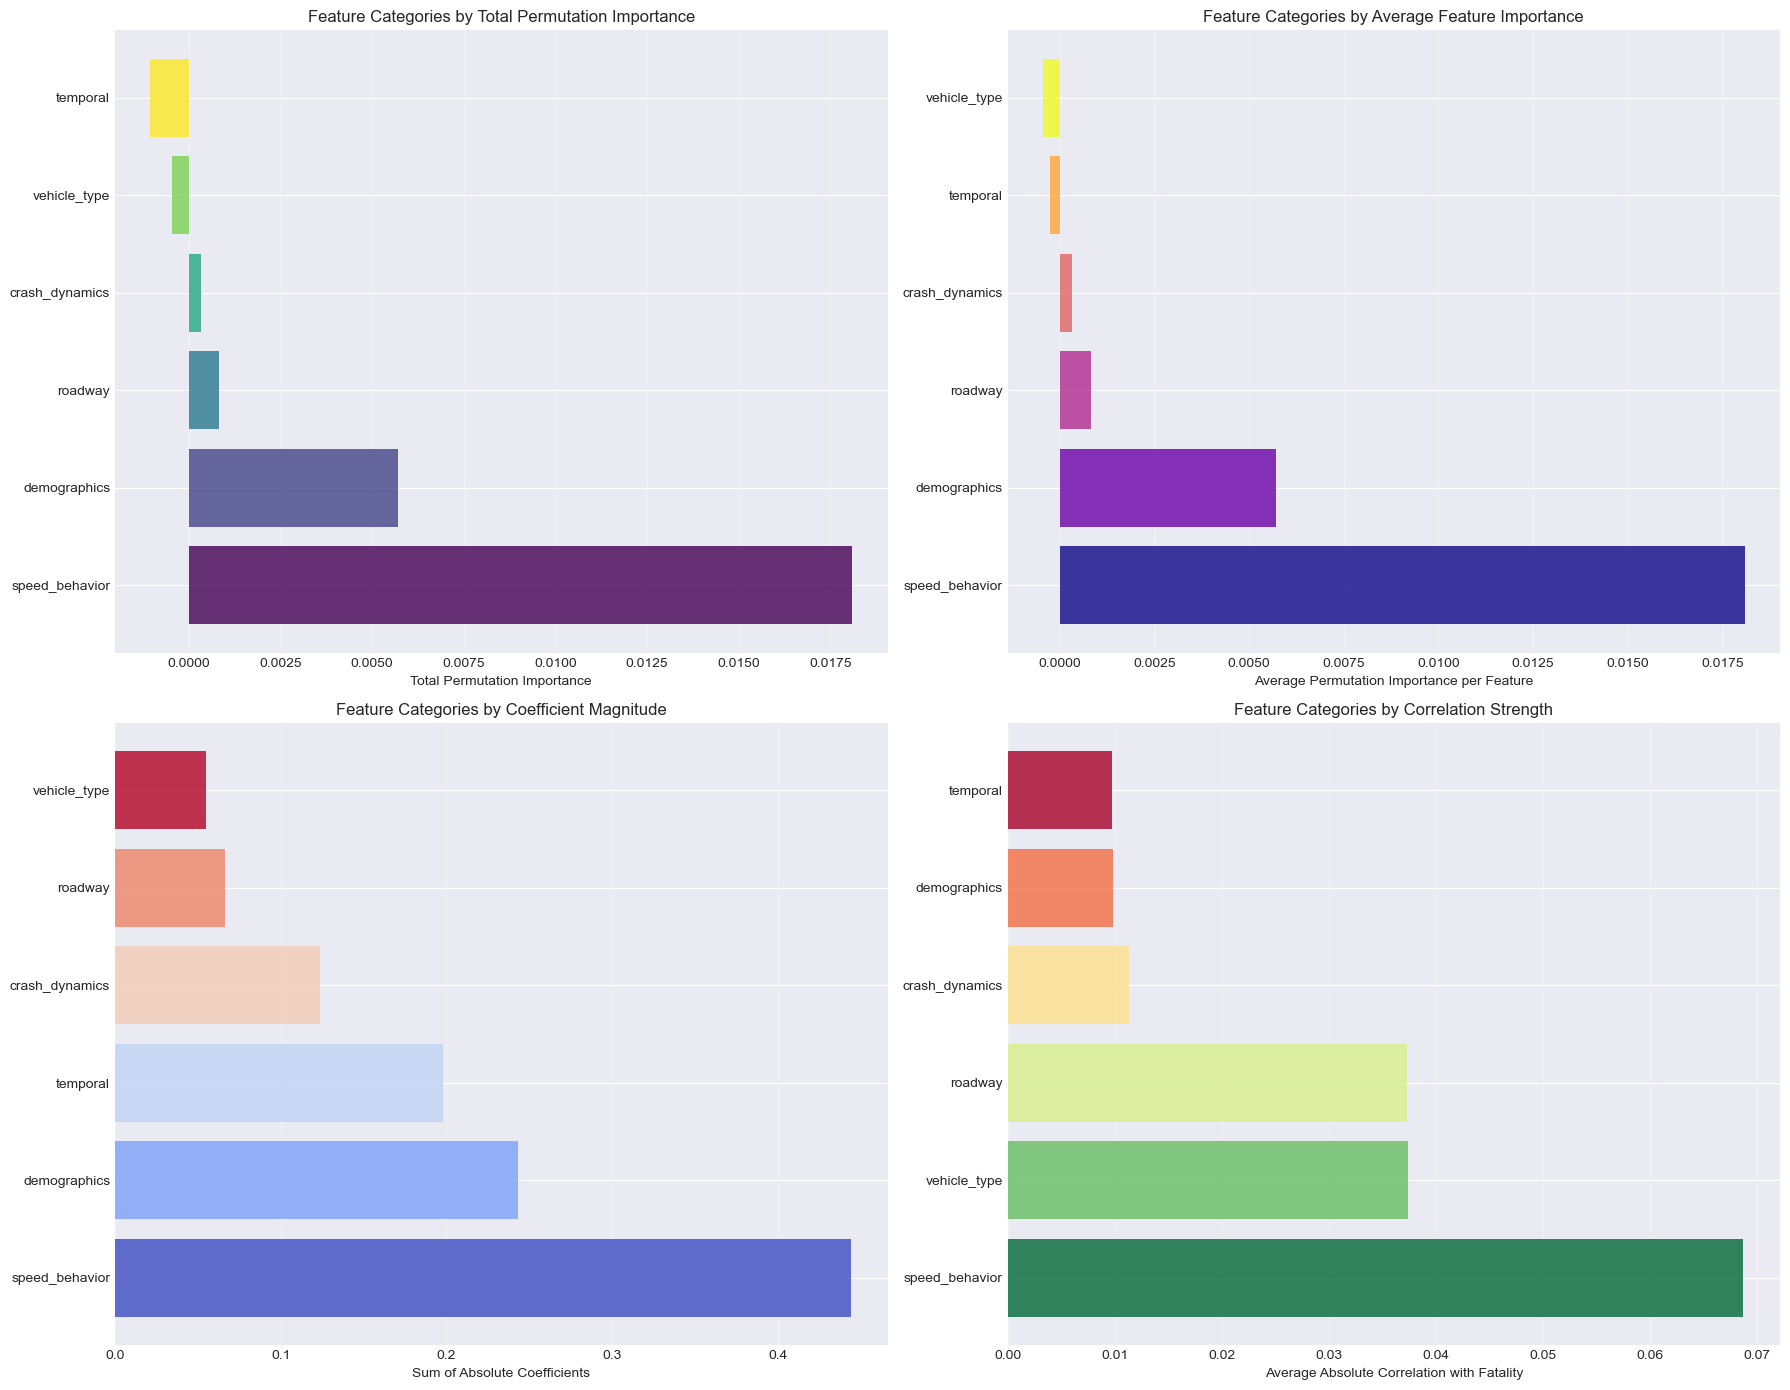

In [24]:
# Visualize category importance
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Total permutation importance
ax = axes[0, 0]
colors = plt.cm.viridis(np.linspace(0, 1, len(category_df)))
ax.barh(range(len(category_df)), category_df['perm_sum'], color=colors, alpha=0.8)
ax.set_yticks(range(len(category_df)))
ax.set_yticklabels(category_df.index)
ax.set_xlabel('Total Permutation Importance')
ax.set_title('Feature Categories by Total Permutation Importance')
ax.grid(axis='x', alpha=0.3)

# 2. Average permutation importance per feature
ax = axes[0, 1]
category_df_sorted = category_df.sort_values('perm_mean', ascending=False)
colors = plt.cm.plasma(np.linspace(0, 1, len(category_df_sorted)))
ax.barh(range(len(category_df_sorted)), category_df_sorted['perm_mean'], 
       color=colors, alpha=0.8)
ax.set_yticks(range(len(category_df_sorted)))
ax.set_yticklabels(category_df_sorted.index)
ax.set_xlabel('Average Permutation Importance per Feature')
ax.set_title('Feature Categories by Average Feature Importance')
ax.grid(axis='x', alpha=0.3)

# 3. Sum of absolute coefficients
ax = axes[1, 0]
category_df_sorted = category_df.sort_values('coef_sum', ascending=False)
colors = plt.cm.coolwarm(np.linspace(0, 1, len(category_df_sorted)))
ax.barh(range(len(category_df_sorted)), category_df_sorted['coef_sum'], 
       color=colors, alpha=0.8)
ax.set_yticks(range(len(category_df_sorted)))
ax.set_yticklabels(category_df_sorted.index)
ax.set_xlabel('Sum of Absolute Coefficients')
ax.set_title('Feature Categories by Coefficient Magnitude')
ax.grid(axis='x', alpha=0.3)

# 4. Average correlation
ax = axes[1, 1]
category_df_sorted = category_df.sort_values('corr_mean', ascending=False)
colors = plt.cm.RdYlGn_r(np.linspace(0, 1, len(category_df_sorted)))
ax.barh(range(len(category_df_sorted)), category_df_sorted['corr_mean'], 
       color=colors, alpha=0.8)
ax.set_yticks(range(len(category_df_sorted)))
ax.set_yticklabels(category_df_sorted.index)
ax.set_xlabel('Average Absolute Correlation with Fatality')
ax.set_title('Feature Categories by Correlation Strength')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# For each category, show top features
print("\n" + "="*80)
print("TOP FEATURES WITHIN EACH CATEGORY")
print("="*80)

for cat_name in category_df.index[:6]:  # Top 6 categories
    cat_info = FEATURE_CATEGORIES[cat_name]
    cat_features = [f for f in cat_info['columns'] if f in X_train.columns]
    
    print(f"\n{'='*80}")
    print(f"{cat_name.upper()}: {cat_info['description']}")
    print(f"{'='*80}")
    
    # Get importance metrics for features in this category
    cat_feature_importance = perm_importance_df[
        perm_importance_df['Feature'].isin(cat_features)
    ].head(10)
    
    if len(cat_feature_importance) > 0:
        print("\nTop features by permutation importance:")
        for i, (_, row) in enumerate(cat_feature_importance.iterrows(), 1):
            feat = row['Feature']
            perm_imp = row['Importance']
            coef = coefficients[coefficients['Feature'] == feat]['Coefficient'].values[0]
            corr = correlations[feat]
            
            direction = "↑ increases" if coef > 0 else "↓ decreases"
            print(f"  {i:2d}. {feat:20s}")
            print(f"      Perm. Importance: {perm_imp:.6f}")
            print(f"      Coefficient: {coef:8.4f} ({direction} risk)")
            print(f"      Correlation: {corr:7.4f}")
            print()


TOP FEATURES WITHIN EACH CATEGORY

SPEED_BEHAVIOR: Speed-related factors

Top features by permutation importance:
   1. VSPD_LIM            
      Perm. Importance: 0.018097
      Coefficient:   0.4440 (↑ increases risk)
      Correlation:  0.0687


DEMOGRAPHICS: Person demographics

Top features by permutation importance:
   1. AGE                 
      Perm. Importance: 0.005703
      Coefficient:   0.2432 (↑ increases risk)
      Correlation:  0.0098


ROADWAY: Road type, junction, traffic control

Top features by permutation importance:
   1. VNUM_LAN            
      Perm. Importance: 0.000835
      Coefficient:  -0.0663 (↓ decreases risk)
      Correlation: -0.0373


CRASH_DYNAMICS: Impact, fire, rollover

Top features by permutation importance:
   1. NUMOCCS             
      Perm. Importance: 0.000335
      Coefficient:   0.1235 (↑ increases risk)
      Correlation:  0.0113


VEHICLE_TYPE: Vehicle characteristics

Top features by permutation importance:
   1. MOD_YEAR      

In [26]:
print("\n" + "="*80)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*80)

print("\n1. DATASET OVERVIEW")
print("-" * 80)
print(f"   Total records: {len(df):,}")
print(f"   Features analyzed: {X_clean.shape[1]}")
print(f"   Fatality rate: {y_clean.mean():.2%}")
print(f"   Class imbalance ratio: {(1-y_clean.mean())/y_clean.mean():.1f}:1")

print("\n2. PRINCIPAL COMPONENT ANALYSIS")
print("-" * 80)
print(f"   Components for 90% variance: {n_components_90}")
print(f"   Components for 95% variance: {n_components_95}")
print(f"   Components for 99% variance: {n_components_99}")
print(f"   Top component explains: {explained_variance_ratio[0]*100:.2f}% variance")

print("\n3. TOP 10 MOST IMPORTANT INDIVIDUAL FEATURES")
print("-" * 80)
for i, (_, row) in enumerate(perm_importance_df.head(10).iterrows(), 1):
    feat = row['Feature']
    imp = row['Importance']
    coef = coefficients[coefficients['Feature'] == feat]['Coefficient'].values[0]
    effect = "↑" if coef > 0 else "↓"
    print(f"   {i:2d}. {feat:25s} Importance: {imp:.6f} {effect}")

print("\n4. MOST INFLUENTIAL FEATURE CATEGORIES")
print("-" * 80)
for i, (idx, row) in enumerate(category_df.head(5).iterrows(), 1):
    print(f"   {i}. {idx:20s} (n={int(row['n_features']):2d} features)")
    print(f"      Total importance: {row['perm_sum']:.6f}")
    print(f"      Avg importance: {row['perm_mean']:.6f}")
    print(f"      Description: {row['description']}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


COMPREHENSIVE ANALYSIS SUMMARY

1. DATASET OVERVIEW
--------------------------------------------------------------------------------
   Total records: 117,033
   Features analyzed: 389
   Fatality rate: 2.15%
   Class imbalance ratio: 45.6:1

2. PRINCIPAL COMPONENT ANALYSIS
--------------------------------------------------------------------------------
   Components for 90% variance: 291
   Components for 95% variance: 317
   Components for 99% variance: 347
   Top component explains: 1.77% variance

3. TOP 10 MOST IMPORTANT INDIVIDUAL FEATURES
--------------------------------------------------------------------------------
    1. HARM_EV_8.0               Importance: 0.034856 ↑
    2. VSPD_LIM                  Importance: 0.018097 ↑
    3. DEFORMED_6.0              Importance: 0.012261 ↑
    4. MAN_COLL_6.0              Importance: 0.010917 ↑
    5. HARM_EV_15.0              Importance: 0.008732 ↑
    6. MAN_COLL_2.0              Importance: 0.007330 ↑
    7. MAN_COLL_7.0           